In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import xarray as xr

from parcels import (grid, Field, FieldSet, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4,
                     ErrorCode, ParticleFile, Variable, plotTrajectoriesFile)

import matplotlib.pyplot as plt
import cartopy as cart
from cartopy import crs as ccrs

from datetime import timedelta as delta
from datetime import datetime

import argparse
from glob import glob
import pickle
import os.path
import warnings
from importlib import reload

import sys
sys.path.append('/science/users/4302001/arctic-connectivity/tools')
sys.path.append('/Users/daanreijnders/surfdrive/Thesis/repo/tools')
import fieldsetter_cmems
import kernelCollection
import community
import advectParticles
import plot

Stripy is not available on this machine.


In [2]:
reload(community)
reload(fieldsetter_cmems)
reload(advectParticles)
reload(plot)

Stripy is not available on this machine.


<module 'plot' from '/science-nfs-sys/vsm01/users/4302001/arctic-connectivity/tools/plot.py'>

In [3]:
readDir = "/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030/"
fieldFiles = sorted(glob(readDir + "mercatorglorys12v1_gl12_mean_*.nc"))

In [4]:
ds = xr.open_dataset(readDir + "mercatorglorys12v1_gl12_unbeaching_vel.nc")

In [95]:
ds

<xarray.Dataset>
Dimensions:    (lat: 2041, latitude: 2041, lon: 4320, longitude: 4320)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.91667 ... 179.83333 179.91667
  * latitude   (latitude) float32 -80.0 -79.916664 -79.833336 ... 89.916664 90.0
Dimensions without coordinates: lat, lon
Data variables:
    unBeachU   (lat, lon) float64 ...
    unBeachV   (lat, lon) float64 ...
    Mask       (lat, lon) float64 ...

In [72]:
start_date = 20181125 #USER_INPUT
startFile = glob(readDir + f"mercatorglorys12v1_gl12_mean_{start_date}_*.nc")
assert len(startFile) == 1, "No file found for this `start_date`."
startFileIndex = fieldfiles.index(startFile[0])

In [73]:
startFileIndex

9459

In [74]:
runDays = 60 #USER_INPUT
endFileIndex = startFileIndex + runDays
if endFileIndex >= len(fieldFiles) - 1:
    runDays = len(fieldFiles) - startFileIndex -1
    endFileIndex = len(fieldFiles) - 1
    warnings.warn("\n Timespan of simulation exceeds the amount of data that is available. " \
                 +"Reducing the amount of `runDays` to " + str(runDays) +".")
selectedFiles = fieldFiles[startFileIndex:endFileIndex]

/science/users/4302001/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: 
 Timespan of simulation exceeds the amount of data that is available. Reducing the amount of `runDays` to 30.
  import sys


In [78]:
ds.latitude[1620:]

<xarray.DataArray 'latitude' (latitude: 421)>
array([55.      , 55.083332, 55.166668, ..., 89.833336, 89.916664, 90.      ],
      dtype=float32)
Coordinates:
  * latitude  (latitude) float32 55.0 55.083332 55.166668 ... 89.916664 90.0
Attributes:
    valid_min:      -80.0
    valid_max:      90.0
    step:           0.08333588
    units:          degrees_north
    unit_long:      Degrees North
    long_name:      Latitude
    standard_name:  latitude
    axis:           Y

In [93]:
np.searchsorted(ds.latitude, 91)

2041

In [77]:
1560 + 12*5

1620

In [83]:
variables = {'U' : 'uo',
             'V' : 'vo'}

dimensions = {'U': {'time' : 'time',
                    'lat' : 'latitude',
                    'lon' : 'longitude'},
              'V': {'time' : 'time',
                    'lat' : 'latitude',
                    'lon' : 'longitude'}}
mesh = fieldFiles[0]
filenames = {'U' : {'lon' : mesh, 
                    'lat' : mesh, 
                    'data' : selectedFiles},
             'V' : {'lon' : mesh, 
                    'lat' : mesh, 
                    'data' : selectedFiles}}  
indices = {'lat': range(1650, 2041)} # Load data from 50N

#ds = xr.open_dataset(fieldfiles[0])
#timestamps = [[ds.time.values[0] + np.timedelta64(day, 'D')] for day in range(500)]
fieldset = FieldSet.from_netcdf(selectedFiles, 
                                variables, 
                                dimensions, 
                                indices = indices,
                                allow_time_extrapolation = False,
                                #timestamps = timestamps,
                               )
fieldset.computeTimeChunk(fieldset.U.grid.time[0], 1)
#fieldset.add_periodic_halo(zonal=True)
fieldset.landMask = np.abs(fieldset.U.data[0,:,:])<0.0000001

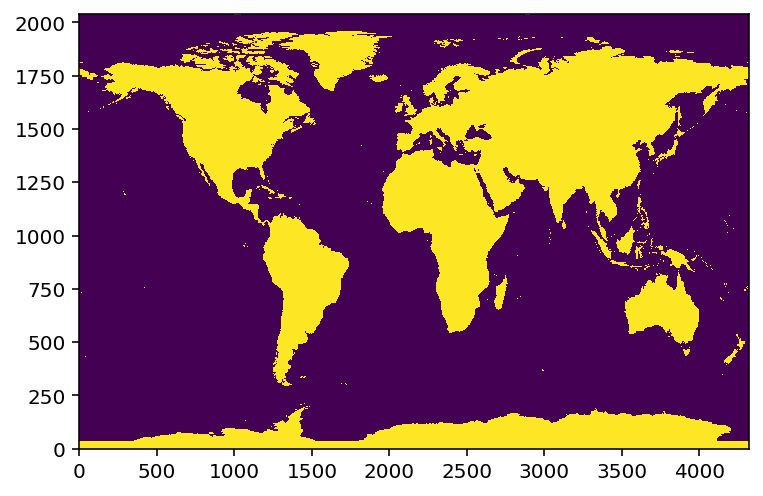

In [37]:
ds = xr.open_dataset(fieldFiles[0])
plt.pcolormesh(np.isnan(ds.uo[0,0,:,:]))

In [44]:
ds.uo

<xarray.DataArray 'uo' (time: 1, depth: 50, latitude: 2041, longitude: 4320)>
[440856000 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.91667 ... 179.83333 179.91667
  * latitude   (latitude) float32 -80.0 -79.916664 -79.833336 ... 89.916664 90.0
  * depth      (depth) float32 0.494025 1.541375 2.645669 ... 5274.784 5727.917
  * time       (time) datetime64[ns] 1993-01-01T12:00:00
Attributes:
    long_name:      Eastward velocity
    standard_name:  eastward_sea_water_velocity
    units:          m s-1
    unit_long:      Meters per second
    valid_min:      -3435
    valid_max:      3378
    cell_methods:   area: mean

In [46]:
fieldset = fieldsetter_cmems.create(20000101, 3, antiBeach=False)

with open(f'/scratch/DaanR/meshes/ico_mesh_parts_deg_arctic_r11.pickle', 'rb') as meshf:
    mesh = pickle.load(meshf)
particles = community.particles(mesh['lons'],
                                mesh['lats'],
                                )


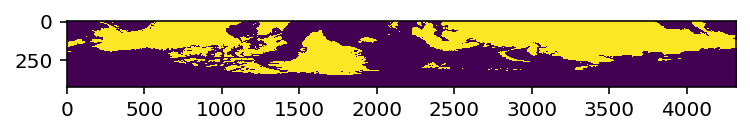

In [47]:
plt.imshow(fieldset.landMask)

In [48]:
particles.remove_on_land(fieldset)

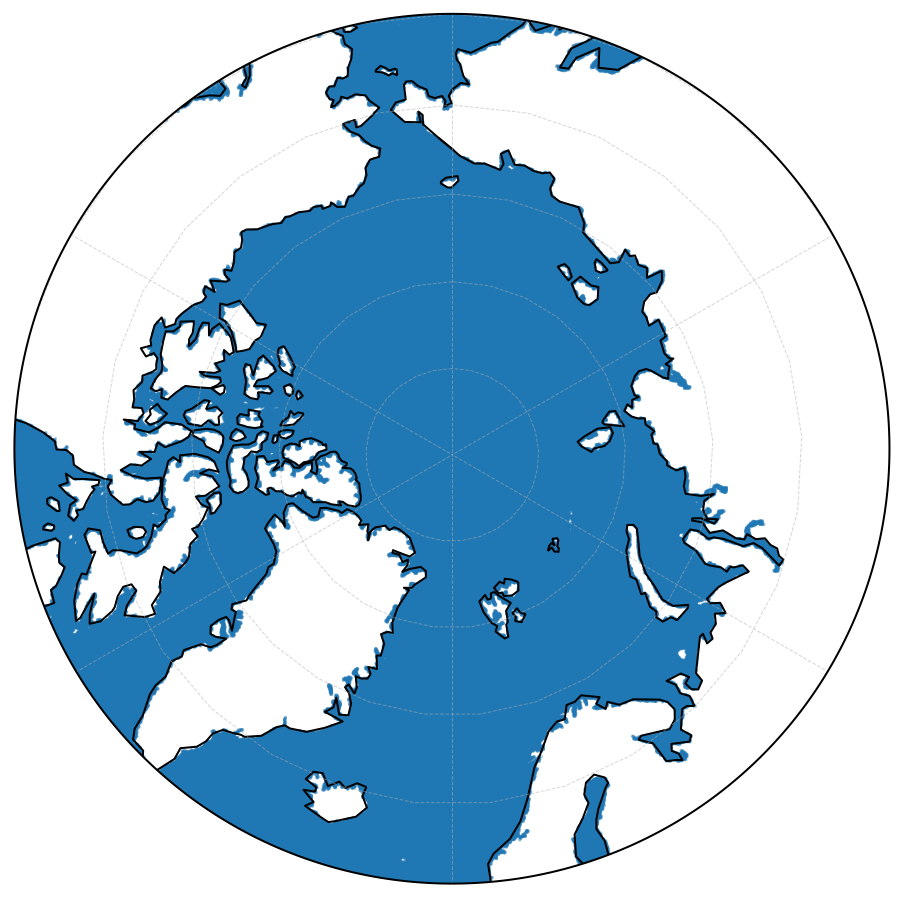

In [51]:
fig, ax = plot.scatter_from_dataset(particles.lons, particles.lats, s=0.01, polar=True, latRange=(60,90), size=(8,8))

(<Figure size 576x576 with 1 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7fea381093c8>)

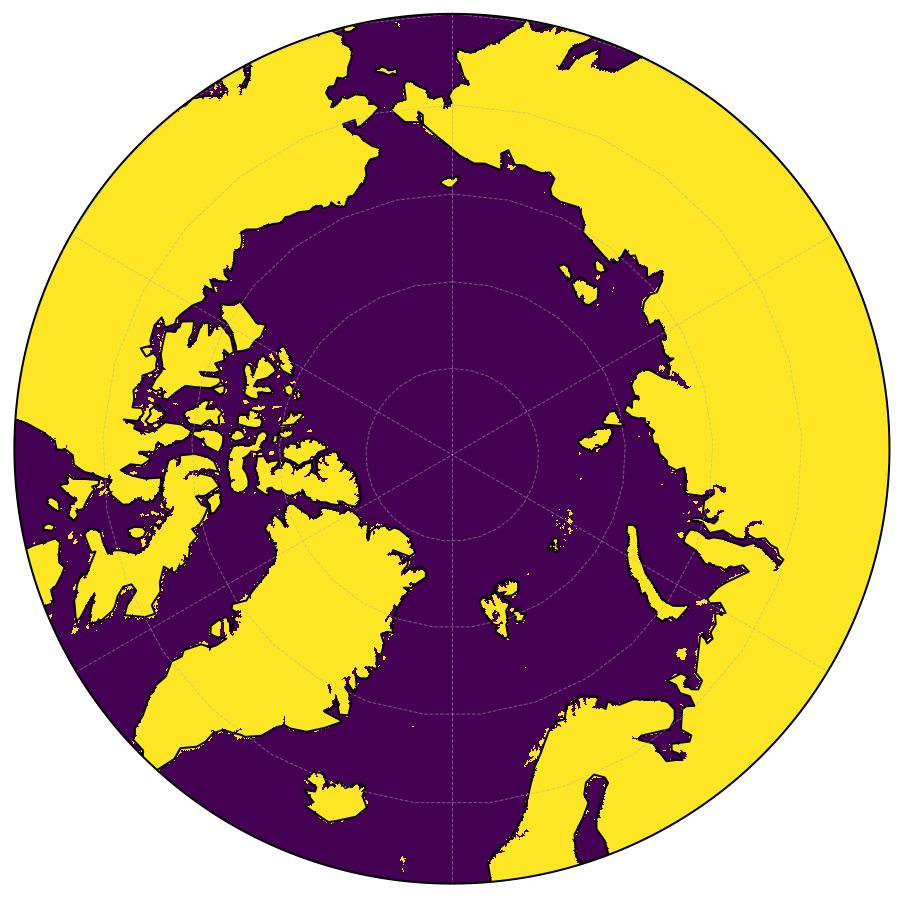

In [55]:
plot.field_from_dataset(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.landMask, polar=True, cbar=False, latRange=(60,90), size=(8,8))

In [86]:
fieldset.U.timestamps

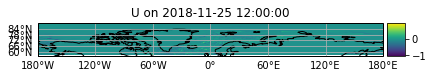

In [84]:
fieldset.U.show()

In [88]:
from datetime import datetime
startTime = datetime(2018, 11, 25, 12)
pset = ParticleSet.from_list(fieldset = fieldset,
                                 pclass = JITParticle,
                                 lon = 80,
                                 lat = 88,
                                 time = startTime,
                                 lonlatdepth_dtype = np.float64)

In [89]:
pset.execute()

INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-23300/30c4bdccbf2b5cd091907eb42a2a2a2d_0.so
N/A% (0 of 2505600.0) |                  | Elapsed Time: 0:00:00 ETA:  --:--:--
 34% (864000.0 of 2505600.0) |###        | Elapsed Time: 0:00:01 ETA:   0:00:02
 37% (950400.0 of 2505600.0) |####       | Elapsed Time: 0:00:02 ETA:   0:00:03
 41% (1036800.0 of 2505600.0) |####      | Elapsed Time: 0:00:03 ETA:   0:00:20
 44% (1123200.0 of 2505600.0) |####      | Elapsed Time: 0:00:04 ETA:   0:00:19
 48% (1209600.0 of 2505600.0) |####      | Elapsed Time: 0:00:05 ETA:   0:00:16
 51% (1296000.0 of 2505600.0) |#####     | Elapsed Time: 0:00:06 ETA:   0:00:15
 55% (1382400.0 of 2505600.0) |#####     | Elapsed Time: 0:00:08 ETA:   0:00:14
 58% (1468800.0 of 2505600.0) |#####     | Elapsed Time: 0:00:09 ETA:   0:00:14
 62% (1555200.0 of 2505600.0) |######    | Elapsed Time: 0:00:10 ETA:   0:00:12
 65% (1641600.0 of 2505600.0) |######    | Elapsed Time: 0:00:11 ETA:   0:00:10
 68% (1728000.0 of 2

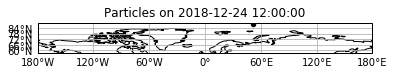

In [90]:
pset.show()

In [ ]:
mesh = fieldFiles[0]
filenames = {'U':   {'lon': mesh_mask, 'lat': mesh_mask, 'data': ifiles},
                 'V':   {'lon': mesh_mask, 'lat': mesh_mask, 'data': ifiles},
                 'sit': {'lon': mesh_mask, 'lat': mesh_mask, 'data': ifiles}, # sea ice thickness
                 'sip': {'lon': mesh_mask, 'lat': mesh_mask, 'data': ifiles}} # sea ice concentration
variables = {'U': 'usi',
                 'V': 'vsi',
                 'sit': 'sithick',
                 'sip': 'siconc'
                }
dimensions = {'lat'  : 'latitude',
                  'lon'  : 'longitude',
                  'time' : 'time'
                  }

    print(filenames)
    fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, allow_time_extrapolation=False)

    '''Add the ocean velocities'''
    dimensionsU = {'data': 'uo', 'lon': 'longitude', 'lat': 'latitude', 'time': 'time'}
    dimensionsV = {'data': 'vo', 'lon': 'longitude', 'lat': 'latitude', 'time': 'time'}
    Uocean = Field.from_netcdf(ifiles, 'Uocean', dimensionsU, fieldtype='U', allow_time_extrapolation=False)
    Vocean = Field.from_netcdf(ifiles, 'Vocean', dimensionsV, fieldtype='V', allow_time_extrapolation=False) #,                                  grid=Uocean.grid, dataFiles=Uocean.dataFiles)
    fieldset.add_field(Uocean)
    fieldset.add_field(Vocean)
    uv_ocean = VectorField('UVocean', fieldset.Uocean, fieldset.Vocean)
    fieldset.add_vector_field(uv_ocean)     

    fieldset.add_periodic_halo(zonal=True)
    fieldset.add_constant('halo_west', fieldset.U.grid.lon[0])
    fieldset.add_constant('halo_east', fieldset.U.grid.lon[-1])
    
    return fieldset

In [117]:
fieldset = fieldsetter.create(20000101, 30)

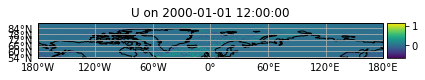

In [119]:
fieldset.U.show()

In [132]:
refinement = 11
with open(f'/scratch/DaanR/meshes/ico_mesh_parts_deg_arctic_r{refinement}.pickle', 'rb') as meshf:
    mesh = pickle.load(meshf)
particles = community.particles(mesh['lons'],
                                    mesh['lats'],
                                    )
particles.remove_on_land(fieldset)

In [135]:
particles.lats

array([63.43494882, 63.43494882, 74.14126279, ..., 89.89335681,
       89.89335681, 89.9690259 ])

In [136]:
mesh

{'lats': array([90.        , 63.43494882, 63.43494882, ..., 89.89335681,
        89.92265108, 89.9690259 ]),
 'lons': array([   0.        , -108.        ,  180.        , ..., -127.96462132,
         -94.38617951,  144.        ])}

In [133]:
particles.n

1441524

In [8]:
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb 
import cartopy as cart

(array([497595., 496480., 440390., 381610., 319405., 268880., 213980.,
        152900.,  92595.,  30986.]),
 array([60.00003437, 63.00003094, 66.0000275 , 69.00002406, 72.00002062,
        75.00001719, 78.00001375, 81.00001031, 84.00000687, 87.00000344,
        90.        ]),
 <a list of 10 Patch objects>)

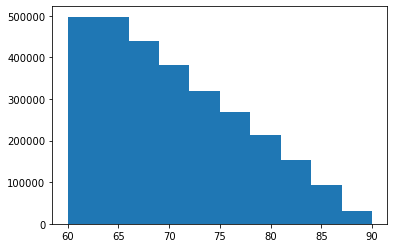

In [131]:
plt.hist(particles.lats)

In [5]:
pfile = xr.open_dataset("/data/oceanparcels/output_data/data_Daan/psets/pset_Rcmems_Pico11_S2001-1-1_D90_DT20_ODT24.nc")

In [6]:
lon = np.ma.filled(pfile.variables['lon'], np.nan)
lat = np.ma.filled(pfile.variables['lat'], np.nan)
time = np.ma.filled(pfile.variables['time'], np.nan)

In [8]:
lon.shape

(1441524, 91)

In [11]:
lon[:,0].shape

(1441524,)

In [14]:
((lat[:,0]-60)/30*100).shape

(1441524,)

In [49]:
hsv = np.dstack((lon[:,0], (lat[:,0]-60)/30*100, 100*np.ones(lat.shape[0])))[0]

In [50]:
hsv[:,0].min()

-179.96298217773438

In [51]:
lat[:,0].max()

89.969025

In [52]:
initcolor = hsv_to_rgb(hsv)

In [55]:
initcolor.shape[0] == lon.shape[0]

True

ValueError: 'c' argument has 1441524 elements, which is not acceptable for use with 'x' with size 1441524, 'y' with size 1441524.

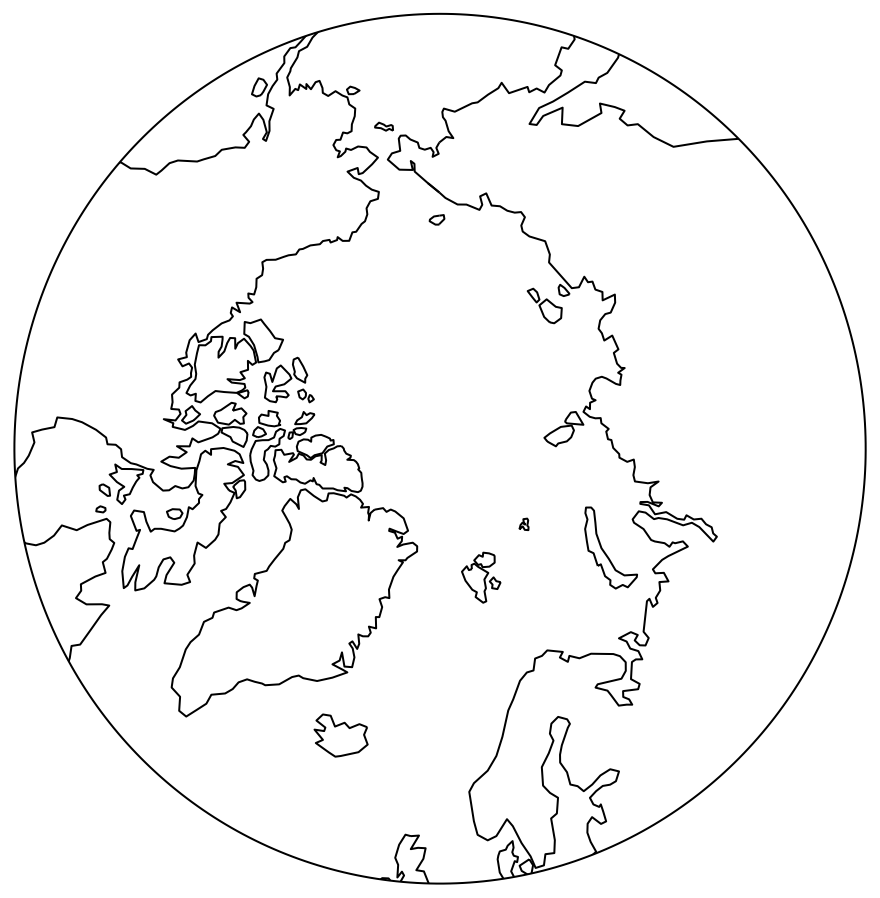

In [54]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection = cart.crs.NorthPolarStereo(central_longitude=0.0, globe=None))
ax.set_extent((-180, 180, 55, 90), crs=cart.crs.PlateCarree())
ax.coastlines()
plot.set_circular_boundary(ax)
scat = ax.scatter(lon[:,0], lat[:,0], c=initcolor, s=0.005, transform=cart.crs.Geodetic(), zorder=10)
scat.set_offsets(np.vstack((lon[:,20], lat[:,20])).transpose())